In [1]:
# 필요한 모듈 불러오기
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import torch
import glob

# 필요한 모듈 가져오기
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
import plotly.offline as py
import plotly.graph_objs as go
%matplotlib inline

In [63]:
# 이미지 불러오기
# path = './data/normal_data/normal_processed_data/*.jpg'
img_list = list()
for take_num in range(1,15):
    take_list = list()
    for file_num in range(121):
        path = '.\\data\\normal_data\\normal_raw_data\\20200518_' + str(file_num) + '_normal_take' + str(take_num) + '.jpg'
        img = np.array(Image.open(path))
        take_list.append(img)
    img_list.append(take_list)
# print(len(img_list))
# print(len(img_list[1]))

# Normal_data 2차 전처리

In [66]:
def imgPreprocessing(src, thres):
    ############################################################################
    # <이미지 노이즈 및 배경 제거>

    # 그레이 스케일로 변환
    gray = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
    
    # 데이터형 변환
    # img_tensor = torch.LongTensor(np.array(img))

    # 바이너리로 변환
    ret, binary = cv2.threshold(gray,thres,255, cv2.THRESH_BINARY)
    binary = cv2.bitwise_not(binary)

    # 바이너리 이미지와 원본 이미지의 데이터가 일치하는 부분 만 다시 추출히기
    # tmp = np.zeros_like(src)
    # for i in range(3):
    #     tmp[:,:,i] = (src[:,:,i] * binary)

    tmp = np.zeros_like(src)
    for y in range(64):
        for x in range(64):
            if (binary != 0)[y,x]:
                for i in range(3):
                    tmp[y,x,i] = src[y,x,i]
    
    src_processed = tmp

    # ax1 = fig.add_subplot(1,3,1)
    # ax1.imshow(src_processed)
    

    height = src_processed.shape[0]
    width = src_processed.shape[1]

    ############################################################################
    # <생두 무게 중심 구하기>
    R = list()
    for y in range(height):
        for x in range(width):
            if binary[y,x]:            
                R.append([x, y])

    # 질량의 합
    M = len(R)

    # 질량중심 벡터는 이미지를 기준으로 (x,y)
    R = np.array(R)
    R_x = R[:,0]
    R_y = R[:,1]

    R_x_sum = R_x.sum()
    R_y_sum = R_y.sum()

    center = np.round(R_x_sum/M).real , (np.round(R_y_sum/M)).real

    height_center = center[1]
    width_center = center[0]

    # print('center:', height_center, width_center)

 
    ############################################################################
    # <객체 외부의 노이즈 데이터 처리하기>

    # 바이너리의 윤곽선 추출
    _, contours, hierachy = cv2.findContours(binary, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)    

    # 생두 객체 윤곽과 윤곽벡터 구하기
    contours_leng = [len(i) for i in contours if len(i) != 252]
    # print('contours_leng: ', contours_leng)
    max = np.array(contours_leng).max()
    # print('max: ', max)
    contour_vector = list()
    for i in contours:
        if len(i) == max:
            # print(i)
            for point in i:
                contour_vector.append((point[0][1]-height_center, point[0][0]-width_center))
            
            # 윤곽 벡터 사이즈와 최대 사이즈 구하기
            vector_size = np.sqrt(np.array(contour_vector)[:,0]**2 + np.array(contour_vector)[:,1]**2 )
            max_size = vector_size.max()
    # print('max_size: ', max_size)

    # 질량 벡터와 윤곽벡터를 비교하는 코드 짜기
    R_size = np.sqrt((R[:,0] - width_center) ** 2 + (R[:,1] - height_center) ** 2)
    R_total = np.hstack([R,R_size.reshape((R_size.shape[0],1))])

    # print('R_size_max: ', R_size.max())
    # max_size 보다 큰 R 좌표들만 추출하기
    R_filtered = R_total[R_total[:,2] > max_size]


    # R_filtered의 좌표를 이용해서 노이즈 처리
    for i in R_filtered[:,:2]:
        # print(i[0].real, -i[1].imag)
        src_processed[int(i[1]),int(i[0])] = 0

    # ax2 = fig.add_subplot(1,3,2)
    # ax2.imshow(binary)
    # ax3 = fig.add_subplot(1,3,3)
    # ax3.imshow(src_processed)


    ############################################################################
    # <이미지의 중심과 생두의 무게중심 일치시키기>
    
    # 1. 이미지 센터 좌표를 구한다 
    src_center = np.array([src_processed.shape[1] / 2, src_processed.shape[0] / 2]) # (x, y)

    # 2. 객체의 중심을 구한다
    object_center = np.array([height_center, width_center]) # (x, y)

    # 3. 이미지 중심과 객체의 중심의 차이를 구한다
    delta = object_center - src_center # (x, y)

    # 4. 이미지 이동
    height, width = src_processed.shape[:2]
    M = np.float32([[1, 0, -delta[1]], [0, 1, -delta[0]]]) # 이미지를 width 방향으로 delta[0]만큼 , hiehgt 방향으로 -delta[1]만큼
    img_translation = cv2.warpAffine(src_processed, M, (width,height))

    return src, binary, src_processed, img_translation

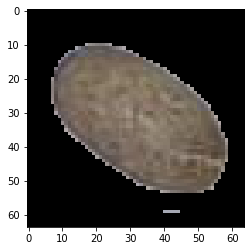

In [76]:
# 이미지 확인
# img_list[take 넘버][img 넘버]
plt.imshow(imgPreprocessing(img_list[3][0],170)[3])

In [74]:
# 데이터 처리
for take_num in range(1,15):
    for file_num in range(121):
        save_path = '.\\data\\normal_data\\normal_sec_processed_data\\20200518_' + str(file_num) + '_normal_take' + str(take_num -1) + '_final.jpg'
        Image.fromarray(imgPreprocessing(img_list[take_num-1][file_num], 170)[3]).save(save_path)

# Broken_data 2차 전처리

In [78]:
# 이미지 불러오기
img_list = list()
for take_num in range(1,15):
    take_list = list()
    for file_num in range(121):
        path = '.\\data\\broken_data\\broken_raw_data\\20200519_' + str(file_num) + '_broken_take' + str(take_num) + '.jpg'
        img = np.array(Image.open(path))
        take_list.append(img)
    img_list.append(take_list)
# print(len(img_list))
# print(len(img_list[1]))

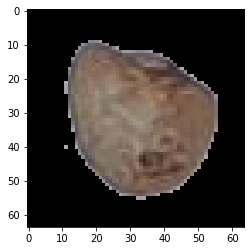

In [79]:
# 이미지 확인
# img_list[take 넘버][img 넘버]
plt.imshow(imgPreprocessing(img_list[3][0],170)[3])

In [80]:
# 데이터 처리
for take_num in range(1,15):
    for file_num in range(121):
        save_path = '.\\data\\broken_data\\broken_sec_processed_data\\20200519_' + str(file_num) + '_broken_take' + str(take_num -1) + '_final.jpg'
        Image.fromarray(imgPreprocessing(img_list[take_num-1][file_num], 170)[3]).save(save_path)